# Julia tests
This python notebook simply uses the available julia scripts in order to test their functionality. Julia's plotting capabilities are not very efficient, so that is better done in Python

In [1]:
long_sims = True

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from julia import Main
basedir = ""

Ha_eV = 27.211386245988 


def cube_disp(kx,ky,kz):
    
    dx = 1
    dy = 1
    dz = 1
    
    return np.cos(kx*dx) + np.cos(ky*dy) + np.cos(kz*dz)

In [2]:

# filename  = "/mnt/data/projects_sync/imperial_nanoparticles/nanoparticle-fgr/examples/bands.txt"
# fname_dos = "/mnt/data/projects_sync/imperial_nanoparticles/nanoparticle-fgr/examples/dos.txt"
# bands = np.loadtxt(filename)
# dos   = np.loadtxt(fname_dos)
# NK = len(bands)

In [3]:
# fig, axs = plt.subplots(figsize=(6.2,6))

# kpp = 30

# dks = [0.2, 0.1, 0.14, 0.17, 0.27]
# k = 0
# kpath = [k]
# for dk in dks:
#     k += dk
#     kpath.append(k)
    
# print(kpath)
# # kpath = [0, 0.2, 0.3, 0.45, 0.60, 0.8]
# Npaths = len(kpath)
# ks = []
# for i in range(Npaths-1):
#     ki = kpath[i]
#     kf = kpath[i+1]
#     ks = ks + list(np.linspace(ki,kf, kpp))[:-1]

# ks.append(kpath[-1])
# print(len(ks), NK)
# xs = [(kpp-1)*i for i in range(Npaths)]

# No = 9
# for i in range(No):
#     band = bands[:,i+3]*Ha_eV
#     kx   = bands[:,0]*2*np.pi
#     ky   = bands[:,1]*2*np.pi
#     kz   = bands[:,2]*2*np.pi
    
#     cube = 0.2*cube_disp(kx, ky, kz) + 0.1
#     axs.plot(ks, band)
#     # plt.plot(ks, cube*Ha_eV, 'k--')
#     # plt.plot(cube+0.1)
# # plt.xlim(130,140)

# # axs.axhline(7.0, c='k', linestyle="--")

# for x in xs:
#     axs.axvline(ks[x], c='k', linewidth=0.4)
# axs.set_ylim([-4,14])

In [4]:
# fig, axs = plt.subplots(figsize=(20,5))
# axs.plot(dos[:,0], dos[:,1])
# L = 8
# ks = np.array([2*np.pi/L*i for i in range(L)])
# print(ks)
# for kx in ks:
#     for ky in ks:
#         for kz in ks:
#             # print(kx, ky, kz)
#             E = cube_disp(kx,ky,kz)*Ha_eV*0.1*2
#             # print(E)
#             axs.axvline(E, c='k', linewidth=0.4)
# axs.set_xlim([-5,25])

# Density of states

## Density of states of 3d tight-binding cubic lattice, small lattice
The 3D TB cubic lattice can be obtained with a slater-koster parametrization. The exact position of the DoS peaks for a small lattice are known and are checked here

In [5]:
Main.include(basedir + "test3D_dos.jl")
L = 4
N = 200
mater = "3DTB"
a = Main.test(L*2,N, mater)
b = Main.test(L*2,N*2, mater)


0
number of atoms: 768
Lower limit is too low, updating
Higher limit is too high, updating
number of atoms: 768
Lower limit is too low, updating
Higher limit is too high, updating


[0.         1.57079633 3.14159265 4.71238898]


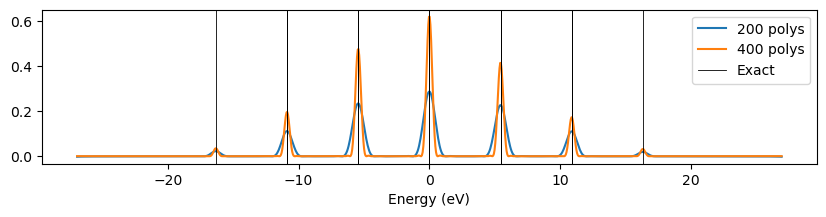

In [6]:
fig, axs = plt.subplots(figsize=(10,2))

axs.plot(a[:,0], a[:,1], label = f"{N} polys")
axs.plot(b[:,0], b[:,1], label = f"{N*2} polys")

ks = np.array([2*np.pi/L*i for i in range(L)])
print(ks)
for kx in ks:
    for ky in ks:
        for kz in ks:
            E = cube_disp(kx,ky,kz)*Ha_eV*0.1*2
            axs.axvline(E, c='k', linewidth=0.6)
axs.axvline(E, c='k', linewidth=0.6, label="Exact")
axs.set_xlabel("Energy (eV)")
axs.legend()
plt.show()

## DoS 3DTB large lattice

In [7]:
# Main.include(basedir + "test3D_dos.jl")
L = 32
N = 400
mater = "3DTB"
dos = Main.test(L*2,N, mater)


number of atoms: 393216
Lower limit is too low, updating
Higher limit is too high, updating


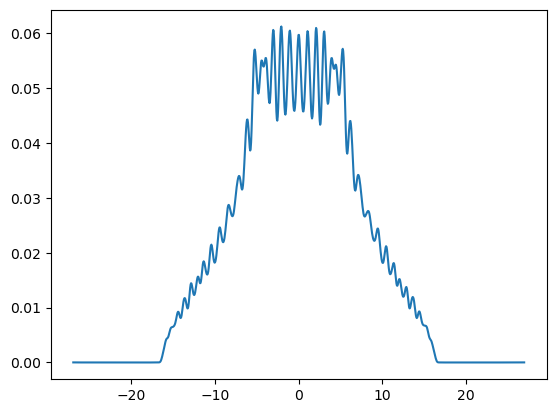

In [8]:
plt.plot(dos[:,0], dos[:,1])
plt.show()

## Dos all materials

In [10]:
Main.include(basedir + "test3D_dos.jl")

0


In [11]:
materials = ["gold", "palladium", "aluminium"]

L = 4
N = 500

dos_list = [Main.test(L,N,material) for material in materials]

number of atoms: 96
Lower limit is too low, updating
number of atoms: 96
Lower limit is too low, updating
number of atoms: 96
Lower limit is too low, updating


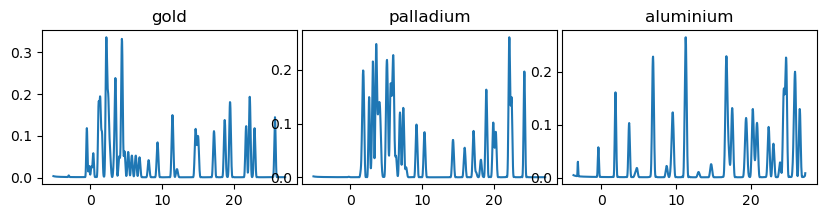

In [12]:

fig, axs = plt.subplots(1,3,figsize=(10,2), sharey=False)
plt.subplots_adjust(wspace=0.02)

for material, dos, ax in zip(materials, dos_list, axs):
    ax.plot(dos[:,0], dos[:,1])
    ax.set_title(material)

plt.show()

# Band structure

## 3D TB

In [12]:
Main.include(basedir + "test3D_bands.jl")
bands = Main.test("3DTB")

0


In [13]:
# Create k-path

kpp = 30

dks = [0.2, 0.1, 0.14, 0.17, 0.27]
k = 0
kpath = [k]
for dk in dks:
    k += dk
    kpath.append(k)
    
print(kpath)

Npaths = len(kpath)
ks = []
for i in range(Npaths-1):
    ki = kpath[i]
    kf = kpath[i+1]
    ks = ks + list(np.linspace(ki,kf, kpp))[:-1]

ks.append(kpath[-1])

print(len(ks))

[0, 0.2, 0.30000000000000004, 0.44000000000000006, 0.6100000000000001, 0.8800000000000001]
146


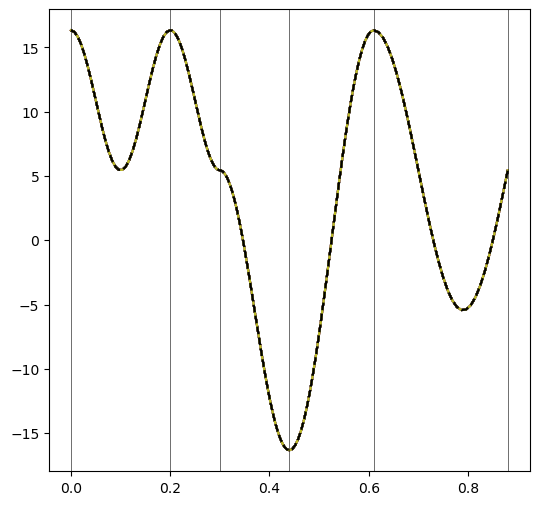

In [14]:

fig, axs = plt.subplots(figsize=(6.2,6))
xs = [(kpp-1)*i for i in range(Npaths)]

No = 9
for i in range(No):
    band = bands[:,i+3]*Ha_eV
    kx   = bands[:,0]*2*np.pi
    ky   = bands[:,1]*2*np.pi
    kz   = bands[:,2]*2*np.pi
    
    cube = 0.2*cube_disp(kx, ky, kz)
    axs.plot(ks, band)
    plt.plot(ks, cube*Ha_eV, 'k--')
    

for x in xs:
    axs.axvline(ks[x], c='k', linewidth=0.4)

## Band structures of all materials

In [15]:
materials = ["gold", "palladium", "aluminium"]
No = 9

xs = [(kpp-1)*i for i in range(Npaths)]
band_list = [Main.test(material) for material in materials]

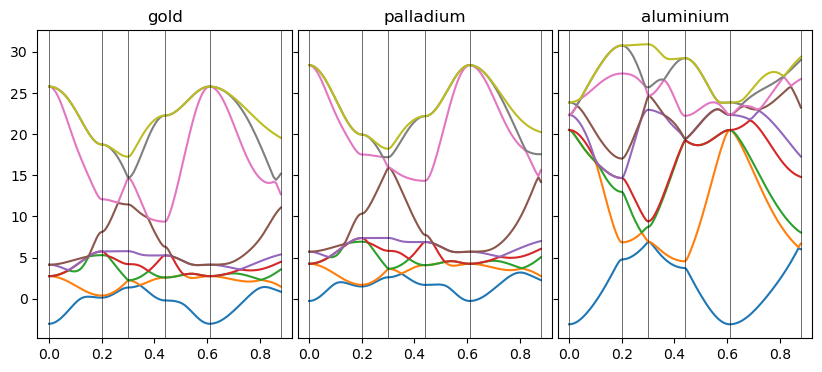

In [16]:

fig, axs = plt.subplots(1,3,figsize=(10,4), sharey=True)
plt.subplots_adjust(wspace=0.02)

for bands, ax, material in zip(band_list, axs, materials):
    ax.set_title(material)
    for i in range(No):
        band = bands[:,i+3]*Ha_eV
        ax.plot(ks, band)

    for x in xs: 
        ax.axvline(ks[x], c='k', linewidth=0.4)

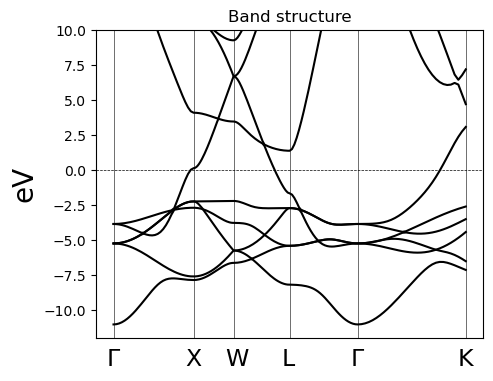

In [50]:
bands = band_list[0]
fig, ax = plt.subplots(1,1,figsize=(5,4))

Ef = 8
ax.set_title("Band structure")
ax.set_ylabel("eV", fontsize=20)
for i in range(No):
    band = bands[:,i+3]*Ha_eV
    ax.plot(ks, band-Ef, color='k')

points = [r"$\Gamma$", "X", "W", "L", r"$\Gamma$", "K"]
for x,p in zip(xs, points): 
    ax.axvline(ks[x], c='k', linewidth=0.4)
    ax.text(ks[x]-0.02,-6-Ef,p, fontsize=17)

ax.set_ylim([-12,10])
ax.axhline(0, linestyle='--', color='k', linewidth=0.5)
ax.get_xaxis().set_visible(False)

# Rest